In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic_2d

## matplotlib parameters to make my life easier
params={     
    'axes.labelsize'  : '16',   
    'axes.titlesize'  : '16',  
    'xtick.labelsize' :'16',
    'ytick.labelsize' :'16',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '9, 7'    
}
plt.rcParams.update(params)

In [2]:
ds_ts = xr.open_mfdataset("/scratch/nf33/hk25_LSP/UK/Darwin/number_size_hourly.nc")


In [3]:
## array to store object number
num_obj_arr = ds_ts["num_obj"].where(np.isfinite(ds_ts["num_obj"]), other=np.nan)

## array for total area
tot_area_arr = ds_ts["tot_area"].where(np.isfinite(ds_ts["tot_area"]), other=np.nan)
## array to store mean cell size
mean_obj_area_arr = ds_ts["mean_obj_area"].where(np.isfinite(ds_ts["mean_obj_area"]), other=np.nan)
## array to store convective area fraction
area_frac_arr = ds_ts["area_frac"].where(np.isfinite(ds_ts["area_frac"]), other=np.nan)*100
## mean precipitation over convective area
cvt_mean_prcp_arr = ds_ts["cvt_mean_prcp"].where(np.isfinite(ds_ts["cvt_mean_prcp"]), other=np.nan)
## mean precipitation over the entire radar scan
tot_mean_prcp_arr = ds_ts["tot_mean_prcp"].where(np.isfinite(ds_ts["tot_mean_prcp"]), other=np.nan)
## total convective precipitation
cvt_tot_prcp_arr = ds_ts["cvt_tot_prcp"].where(np.isfinite(ds_ts["cvt_tot_prcp"]), other=np.nan)

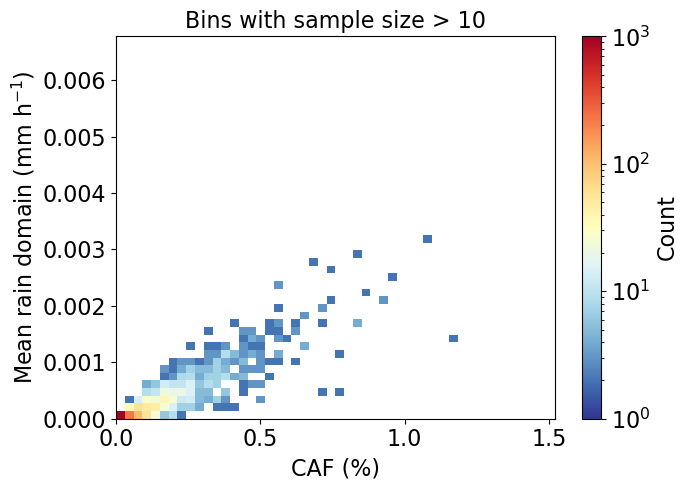

In [4]:
# your data
x = area_frac_arr
y = tot_mean_prcp_arr

# 1) compute the raw 2D histogram
counts, xedges, yedges = np.histogram2d(
    x, y,
    bins=50,
    range=[[x.min(), x.max()], [y.min(), y.max()]]
)

# 2) mask out bins with ≤ 10 samples
counts_masked = np.where(counts > 1, counts, np.nan)

# 3) build the mesh to plot
X, Y = np.meshgrid(xedges, yedges)

plt.figure(figsize=(7, 5))
pcm = plt.pcolormesh(
    X, Y, counts_masked.T,       # note the transpose
    norm=LogNorm(vmin=1, vmax=1000),
    cmap='RdYlBu_r',
    shading='auto'
)
plt.colorbar(pcm, label="Count")
plt.xlabel("CAF (%)")
plt.ylabel("Mean rain domain (mm h$^{-1}$)")
plt.title("Bins with sample size > 10")
plt.tight_layout()
plt.show()

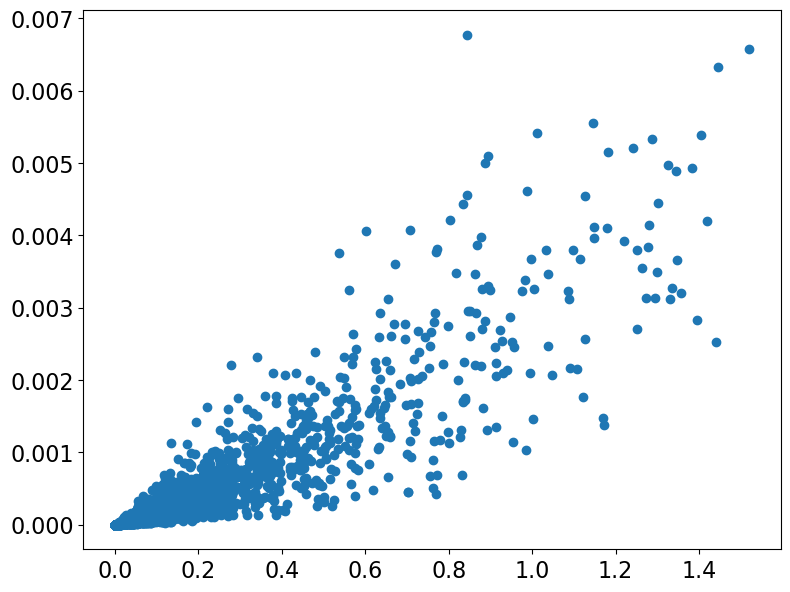

In [5]:
plt.scatter(x,y)

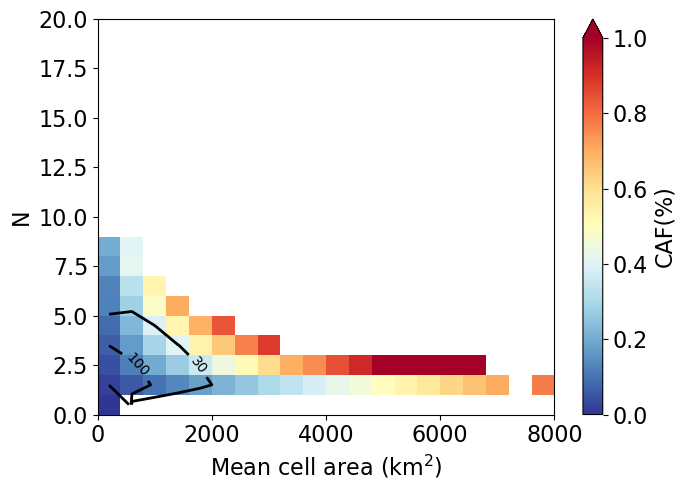

In [13]:
x = mean_obj_area_arr.values
y = num_obj_arr.values
z = area_frac_arr.values

xbins, ybins = 20, 20
xrange = [0,8000]
yrange = [0, 20]
## mask out nans
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x2, y2, z2 = x[mask], y[mask], z[mask]

stat, xedges, yedges, _ = binned_statistic_2d(
    x2,y2,z2,
    statistic='mean',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)
## count
counts, _, _, _ = binned_statistic_2d(
    x2, y2, None, statistic='count',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

## mask out bins with ≤ 1 samples
stat[counts <= 1] = np.nan
# make a mesh for pcolormesh
X, Y = np.meshgrid(xedges, yedges, indexing='xy')

fig, ax = plt.subplots(figsize=(7,5))
pcm = ax.pcolormesh(
    X, Y, stat.T,           # note the transpose
    cmap='RdYlBu_r',
    shading='auto', vmax=1,
)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
fig.colorbar(pcm, ax=ax, label="CAF(%)",extend="max")
cs = ax.contour(x_centers, y_centers,counts.T, levels=[30,100,400],colors="k",)
ax.clabel(cs, inline=True, fontsize=10, fmt="%.0f")
ax.set_xlabel("Mean cell area (km$^2$)")
ax.set_ylabel('N')
# ax.set_title()
plt.tight_layout()